In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

#from string import punctuation

from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# NLP libraires

import gensim # pip install gensim
from gensim.models.word2vec import Word2Vec # word2vec model gensim class
TaggedDocument = gensim.models.doc2vec.TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


导入数据

In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/sentiment324/Train.csv", encoding='UTF-8')

In [ ]:
df_valid = pd.read_csv("/content/drive/My Drive/sentiment324/Valid.csv", encoding='UTF-8')

In [ ]:
df_test = pd.read_csv("/content/drive/My Drive/sentiment324/Test.csv", encoding='UTF-8')

In [ ]:
data = pd.concat([df_train,df_valid])
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


分析数据

In [ ]:
def split_df(df_row):
    return len(str(df_row).split())
len_data_dist = np.vectorize(split_df)(data['text'])
len_test_dist = np.vectorize(split_df)(df_test['text'])

In [ ]:
print(pd.Series(len_data_dist).describe())
print(pd.Series(len_test_dist).describe())

count    45000.000000
mean       231.071844
std        170.988600
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
dtype: float64
count    5000.000000
mean      231.922800
std       174.525522
min        10.000000
25%       128.000000
50%       173.000000
75%       278.000000
max      2108.000000
dtype: float64


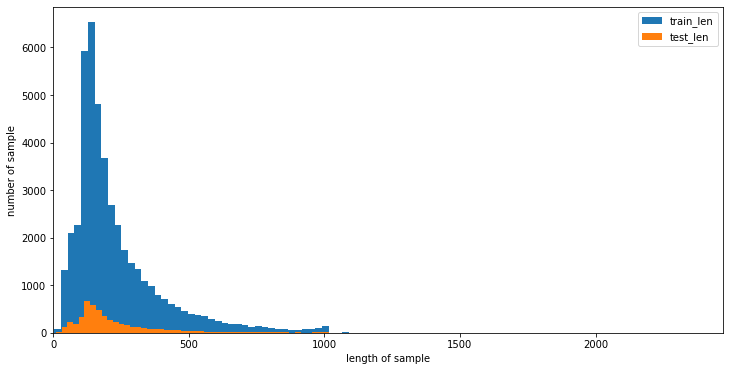

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax = plt.hist(x=len_data_dist, bins=100)
ax = plt.hist(x=len_test_dist, bins=100)
plt.xlim([0, max(max(len_data_dist), max(len_test_dist))])
plt.xlabel("length of sample")
plt.ylabel("number of sample")
plt.legend(['train_len','test_len'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


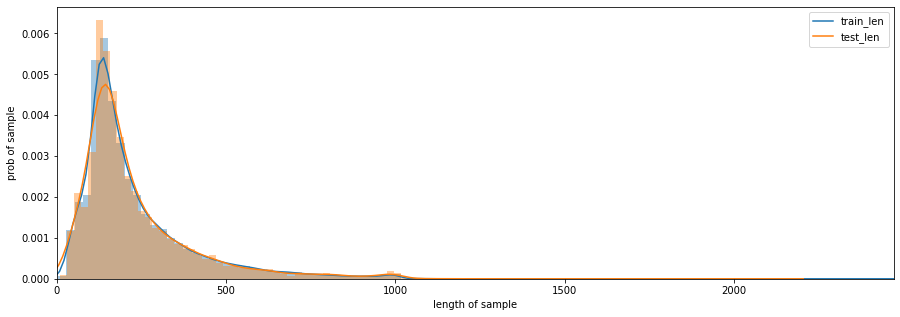

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.distplot(len_data_dist, bins=100)
ax = sns.distplot(len_test_dist, bins=100)
plt.xlim([0, max(max(len_data_dist), max(len_test_dist))])
plt.xlabel("length of sample")
plt.ylabel("prob of sample")
plt.legend(['train_len','test_len'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


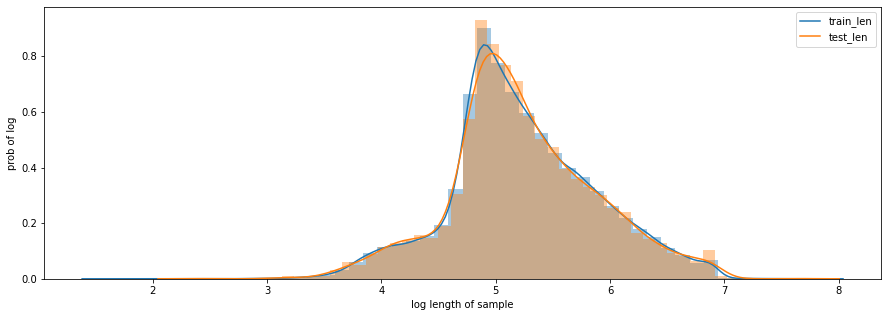

In [ ]:
log_len_data_dist = np.log(1+len_data_dist)
log_len_test_dist = np.log(1+len_test_dist)
plt.figure(figsize=(15,5))
ax = sns.distplot(log_len_data_dist)
ax = sns.distplot(log_len_test_dist)
plt.xlabel("log length of sample")
plt.ylabel("prob of log")
plt.legend(['train_len','test_len'])

In [ ]:
import scipy
from scipy.stats import kstest
from scipy import stats

In [ ]:
_, lognormal_ks_pvalue = scipy.stats.kstest(rvs=log_len_data_dist, cdf='norm')
print('P value is ', lognormal_ks_pvalue)

P value is  0.0


截断长度

In [ ]:
np.exp(7)

1096.6331584284585

预处理数据（nltk）

In [ ]:
import nltk
nltk.download('punkt')
import string
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import keras
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
import re
def preprocessor(text):
             text=re.sub('<[^>]*>','',text)
             emojis=re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
             text=re.sub('[\W]+',' ',text.lower()) +\
                ' '.join(emojis).replace('-','')
             return text   


In [ ]:
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(data))

In [ ]:
data['text']=data['text'].apply(preprocessor)
df_test['text']=df_test['text'].apply(preprocessor)

In [ ]:
data.head()

,text,label
0,i grew up b 1965 watching and loving the thund...,0
1,when i put this movie in my dvd player and sat...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


In [ ]:
from nltk.stem.porter import PorterStemmer

porter=PorterStemmer()

In [ ]:
def tokenizer(text):
        return text.split()

In [ ]:
data.head()

,text,label
0,"[i, grew, up, b, 1965, watching, and, loving, ...",0
1,"[when, i, put, this, movie, in, my, dvd, playe...",0
2,"[why, do, people, who, do, not, know, what, a,...",0
3,"[even, though, i, have, great, interest, in, b...",0
4,"[im, a, die, hard, dads, army, fan, and, nothi...",1


In [ ]:
data['text'] = data['text'].apply(tokenizer)


In [ ]:
df_test['text'] = df_test['text'].apply(tokenizer)

In [ ]:
data['text']

0       [i, grew, up, b, 1965, watching, and, loving, ...
1       [when, i, put, this, movie, in, my, dvd, playe...
2       [why, do, people, who, do, not, know, what, a,...
3       [even, though, i, have, great, interest, in, b...
4       [im, a, die, hard, dads, army, fan, and, nothi...
                              ...                        
4995    [man, i, loved, this, movie, this, really, tak...
4996    [recovery, is, an, incredibly, moving, piece, ...
4997    [you, can, take, the, crook, out, of, the, joi...
4998    [futz, is, the, only, show, preserved, from, t...
4999    [the, mother, tells, of, a, recently, widowed,...
Name: text, Length: 45000, dtype: object

In [ ]:
porter_stemmer = PorterStemmer()
data['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in data['text']]
data['stemmed_tokens']

0       [i, grew, up, b, 1965, watch, and, love, the, ...
1       [when, i, put, thi, movi, in, my, dvd, player,...
2       [whi, do, peopl, who, do, not, know, what, a, ...
3       [even, though, i, have, great, interest, in, b...
4       [im, a, die, hard, dad, armi, fan, and, noth, ...
                              ...                        
4995    [man, i, love, thi, movi, thi, realli, take, m...
4996    [recoveri, is, an, incred, move, piec, of, wor...
4997    [you, can, take, the, crook, out, of, the, joi...
4998    [futz, is, the, onli, show, preserv, from, the...
4999    [the, mother, tell, of, a, recent, widow, mid,...
Name: stemmed_tokens, Length: 45000, dtype: object

In [ ]:
df_test['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df_test['text']]
df_test['stemmed_tokens']

0       [i, alway, wrote, thi, seri, off, as, be, a, c...
1       [1st, watch, 12, 7, 2002, 3, out, of, 10, dir,...
2       [thi, movi, wa, so, poorli, written, and, dire...
3       [the, most, interest, thing, about, miryang, s...
4       [when, i, first, read, about, berlin, am, meer...
                              ...                        
4995    [thi, is, the, kind, of, pictur, john, lassit,...
4996    [a, must, see, i, saw, whip, at, a, press, scr...
4997    [nbc, should, be, asham, i, wouldn, t, allow, ...
4998    [thi, movi, is, a, clumsi, mishmash, of, vario...
4999    [formula, movi, about, the, illegitim, son, of...
Name: stemmed_tokens, Length: 5000, dtype: object

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop=stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
df_test['no_stop'] = [[word for word in tokens if word not in stop] for tokens in df_test['text']]
df_test['no_stop']

0       [always, wrote, series, complete, stink, fest,...
1       [1st, watched, 12, 7, 2002, 3, 10, dir, steve,...
2       [movie, poorly, written, directed, fell, aslee...
3       [interesting, thing, miryang, secret, sunshine...
4       [first, read, berlin, meer, expect, much, thou...
                              ...                        
4995    [kind, picture, john, lassiter, would, making,...
4996    [must, see, saw, whipped, press, screening, hi...
4997    [nbc, ashamed, allow, children, see, definitel...
4998    [movie, clumsy, mishmash, various, ghost, stor...
4999    [formula, movie, illegitimate, son, rich, chil...
Name: no_stop, Length: 5000, dtype: object

In [ ]:
data['no_stop'] = [[word for word in tokens if word not in stop] for tokens in data['text']]
data['no_stop']

0       [grew, b, 1965, watching, loving, thunderbirds...
1       [put, movie, dvd, player, sat, coke, chips, ex...
2       [people, know, particular, time, past, like, f...
3       [even, though, great, interest, biblical, movi...
4       [im, die, hard, dads, army, fan, nothing, ever...
                              ...                        
4995    [man, loved, movie, really, takes, back, kid, ...
4996    [recovery, incredibly, moving, piece, work, ha...
4997    [take, crook, joint, seems, exceedingly, diffi...
4998    [futz, show, preserved, experimental, theatre,...
4999    [mother, tells, recently, widowed, mid, 60, mo...
Name: no_stop, Length: 45000, dtype: object

word2vec

In [ ]:
vec_dim = 50
total_data = pd.concat([data['no_stop'],df_test['no_stop']])

# Model word2vec:
total_data_w2v = Word2Vec(size=vec_dim, min_count=5) 

# Building the vocabulary:
total_data_w2v.build_vocab(total_data)

# Training the model:
total_data_w2v.train(total_data, total_examples=total_data_w2v.corpus_count, epochs=total_data_w2v.epochs)

(28237105, 29896745)

In [ ]:
len(total_data_w2v.wv.vocab)

39602

In [ ]:

total_data_w2v.save("total_data_w2v.h5")

In [ ]:
total_data_w2v.wv['sad']

array([-2.0428395 ,  0.51034087, -0.92333305,  1.6745832 , -0.07080913,
        0.9986323 ,  0.02662858,  1.8398416 , -1.0563176 , -1.508779  ,
        1.1695461 ,  0.14746764,  0.87842524,  0.6696353 , -1.0615405 ,
        0.86614585, -2.4695985 ,  1.4295245 ,  0.9860187 , -0.69593537,
        0.39617226,  0.31052637, -1.4401135 ,  0.83622396, -0.7708041 ,
       -0.16816096,  1.5535235 ,  1.2886043 ,  0.2263467 ,  0.876058  ,
        1.2395419 ,  0.45625073,  0.5905786 ,  1.1574581 ,  1.73241   ,
        1.3319947 , -0.5115233 , -1.1395185 ,  1.2446511 ,  0.12588689,
        0.07613489, -0.21934855, -0.40172595, -1.1182953 , -2.2951567 ,
       -2.8642647 , -2.205136  ,  1.1848174 , -1.3732182 ,  1.1786618 ],
      dtype=float32)

In [ ]:
total_data_w2v.wv.most_similar('sad')

[('honest', 0.6700061559677124),
 ('touching', 0.6551198363304138),
 ('depressing', 0.6520717740058899),
 ('cried', 0.6450546979904175),
 ('touched', 0.627734899520874),
 ('happy', 0.6148889660835266),
 ('cry', 0.6116873621940613),
 ('sick', 0.6059133410453796),
 ('heartwarming', 0.5792145133018494),
 ('frustrating', 0.5767905116081238)]

LSTM

padding

In [ ]:
index2word = list(total_data_w2v.wv.vocab)
embedding_matrix = total_data_w2v.wv[index2word]

padding_vector = np.zeros((1, vec_dim))
index2word.insert(0,'()')
index2word = np.array(index2word)

word2index = dict(zip(index2word, range(len(index2word))))

embedding_matrix = np.vstack((padding_vector, embedding_matrix))

print(np.shape(index2word))
print(np.shape(embedding_matrix))

(39603,)
(39603, 50)


定义X_train_code

In [ ]:
def code_word(y):
    try:
        return word2index[y]
    except KeyError:
        return

X_train_coded = []
for text in data['no_stop']:
    X_train_coded.append([y for y in [code_word(x) for x in text] if y != None])

X_test_coded = []
for text in df_test['no_stop']:
    X_test_coded.append([y for y in [code_word(x) for x in text] if y != None])

In [ ]:
aux = [len(x) for x in X_train_coded]
i = np.argmax(aux)
text_mas_palabras = X_train_coded[i]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


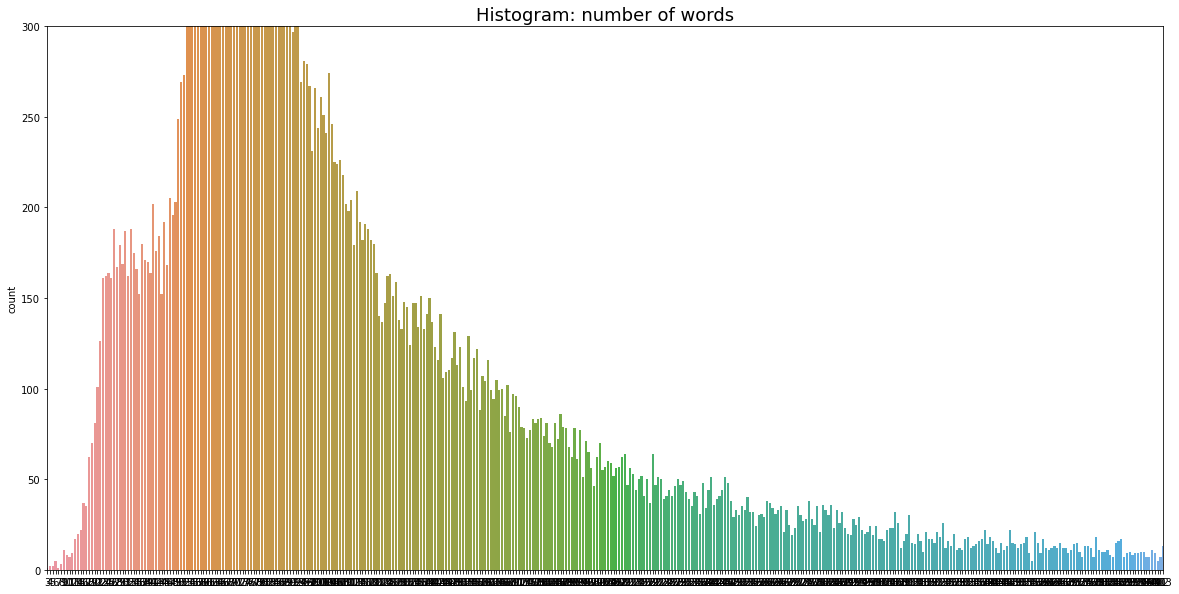

In [ ]:
plt.figure(figsize=(20,10))
f = sns.countplot(aux)
plt.axis([0,400,0,300])
plt.title("Histogram: number of words", fontsize=18);

define the number of word per review

In [ ]:
max_words_text = 1096

from keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_coded, maxlen=max_words_text)
X_test_pad  = pad_sequences(X_test_coded,  maxlen=max_words_text)

In [ ]:
import keras
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Activation, Dense

embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=max_words_text,
                            trainable=False)

双向的LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1096, 50)          1980150   
_________________________________________________________________
bidirectional (Bidirectional (None, 1096, 50)          15200     
_________________________________________________________________
dense (Dense)                (None, 1096, 1)           51        
Total params: 1,995,401
Trainable params: 15,251
Non-trainable params: 1,980,150
_________________________________________________________________
None


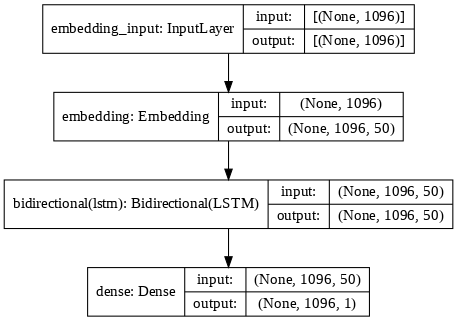

In [ ]:
from tensorflow.keras.layers import Bidirectional
set_dropout=False

model4 = Sequential()
model4.add(embedding_layer)
if set_dropout:
    model4.add(Dropout(0.3))
model4.add(Bidirectional(LSTM(25, return_sequences=True)))
if set_dropout:
    model4.add(Dropout(0.1))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy']) #    'adam'
print(model4.summary())
tf.keras.utils.plot_model(model=model4,show_shapes=True,dpi=76)

In [ ]:
y_train = data["label"][:len(data)].values
y_test = df_test["label"][:len(df_test)].values

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.cluster import KMeans


BATCH_SIZE = 256
nepochs = 5
TRAIN2 = True
filepath4 = "B_LSTM_model.h5"


if TRAIN2:
    acum_tr_acc = []
    acum_val_acc = []
    checkpoint = ModelCheckpoint(filepath4, monitor='val_accuracy', verbose=1,
                                 save_best_only=True,
                                 mode='max') 
    callbacks_list = [checkpoint]


    history = model4.fit(X_train_pad, y_train,
                             batch_size=BATCH_SIZE,
                             epochs=10,
                             verbose=1,
                             callbacks=callbacks_list,
                             validation_split=0.3,
                             shuffle=False,
                            )
    
    acum_tr_acc = acum_tr_acc + history.history['accuracy']
    acum_val_acc = acum_val_acc + history.history['val_accuracy']


model4 = load_model(filepath4)




NameError: ignored

Text(0.5, 0, 'epoch')

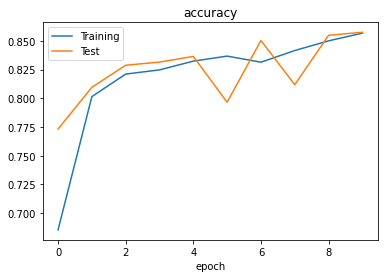

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Test'])
plt.title('accuracy')
plt.xlabel('epoch')

CNN

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1096, 50)          1980150   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1089, 64)          25664     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 544, 64)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 544, 32)           2080      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 2,007,927
Trainable params: 27,777
Non-trainable params: 1,980,150
_______________________________________

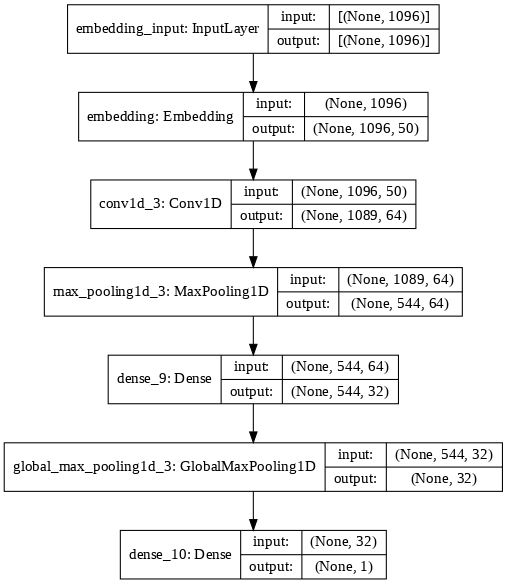

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 
set_dropout=False

# create the model
model3 = Sequential()
model3.add(embedding_layer)
if set_dropout:
    model3.add(Dropout(1.2))
model3.add(Conv1D(64, 8, activation = 'relu'))
#here 64 is number of filters and 8 is size of filters
model3.add(MaxPooling1D(2))
model3.add(Dense(32, activation='relu'))
model3.add(GlobalMaxPooling1D())
if set_dropout:
    model3.add(Dropout(0.3))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy']) #    'adam'
print(model3.summary())
tf.keras.utils.plot_model(model=model3,show_shapes=True,dpi=76)

In [ ]:
y_train_cnn = data["label"][:len(data)].values
y_test_cnn = df_test["label"][:len(df_test)].values

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.cluster import KMeans


BATCH_SIZE = 256
nepochs = 5
TRAIN2 = True
filepath3 = "CNN_model.h5"


if TRAIN2:
    acum_tr_acc = []
    acum_val_acc = []
    checkpoint = ModelCheckpoint(filepath3, monitor='val_accuracy', verbose=1,
                                 save_best_only=True,
                                 mode='max') 
    callbacks_list = [checkpoint]


    history = model3.fit(X_train_pad, y_train_cnn,
                             batch_size=BATCH_SIZE,
                             epochs=10,
                             verbose=1,
                             callbacks=callbacks_list,
                             validation_split=0.3,
                             shuffle=False,
                            )
    
    acum_tr_acc = acum_tr_acc + history.history['accuracy']
    acum_val_acc = acum_val_acc + history.history['val_accuracy']


model3 = load_model(filepath3)




Epoch 1/10
124/124 [==============================] - 12s 81ms/step - loss: 0.6169 - accuracy: 0.7185 - val_loss: 0.4261 - val_accuracy: 0.7982

Epoch 00001: val_accuracy improved from -inf to 0.79816, saving model to CNN_model.h5
Epoch 2/10
124/124 [==============================] - 10s 78ms/step - loss: 0.3492 - accuracy: 0.8511 - val_loss: 0.3477 - val_accuracy: 0.8448

Epoch 00002: val_accuracy improved from 0.79816 to 0.84475, saving model to CNN_model.h5
Epoch 3/10
124/124 [==============================] - 10s 77ms/step - loss: 0.3099 - accuracy: 0.8689 - val_loss: 0.3390 - val_accuracy: 0.8527

Epoch 00003: val_accuracy improved from 0.84475 to 0.85268, saving model to CNN_model.h5
Epoch 4/10
124/124 [==============================] - 10s 77ms/step - loss: 0.2837 - accuracy: 0.8826 - val_loss: 0.3398 - val_accuracy: 0.8531

Epoch 00004: val_accuracy improved from 0.85268 to 0.85312, saving model to CNN_model.h5
Epoch 5/10
124/124 [==============================] - 10s 78ms/step

Text(0.5, 0, 'epoch')

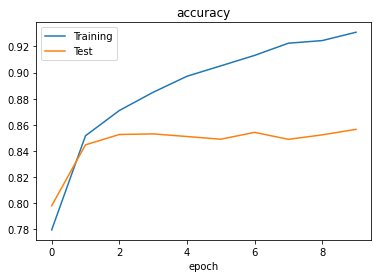

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Test'])
plt.title('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

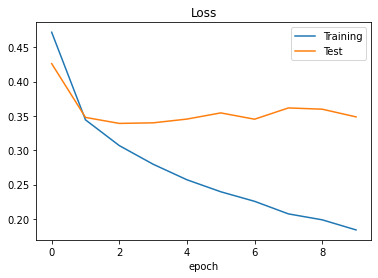

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Test'])
plt.title('Loss')
plt.xlabel('epoch')

In [ ]:
y_train_pred_prob3 = model3.predict(X_train_pad)
y_test_pred_prob3  = model3.predict(X_test_pad)

y_train_pred3 = y_train_pred_prob3.round()
y_test_pred3  = y_test_pred_prob3.round()

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [ ]:
score_train3 = accuracy_score(y_train, y_train_pred3)
score_test3  = accuracy_score(y_test,  y_test_pred3)

print("Accuracy (training): %.2f%%" % (100*score_train3))
print("Accuracy (test)    : %.2f%%" % (100*score_test3))

LSTM_model


In [ ]:
set_dropout=False

# create the model
model2 = Sequential()
#model2.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length,
#                    activity_regularizer='l2'))
model2.add(embedding_layer)
if set_dropout:
    model2.add(Dropout(0.2))
#model2.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model2.add(LSTM(25, return_sequences=True))
model2.add(LSTM(25))
if set_dropout:
    model2.add(Dropout(0.4))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy']) #    'adam'

In [ ]:
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1096, 50)          1980150   
_________________________________________________________________
lstm (LSTM)                  (None, 1096, 25)          7600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 1,992,876
Trainable params: 12,726
Non-trainable params: 1,980,150
_________________________________________________________________
None


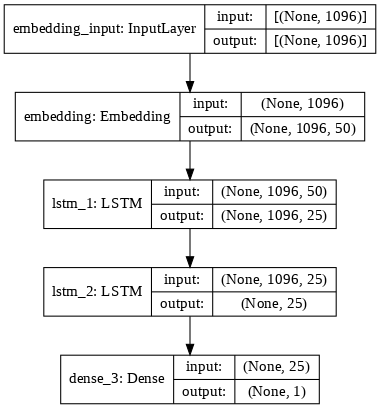

In [ ]:
tf.keras.utils.plot_model(model=model2,show_shapes=True,dpi=76)

In [ ]:
y_train = data["label"][:len(data)].values
y_test = df_test["label"][:len(df_test)].values

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.cluster import KMeans


BATCH_SIZE = 256
nepochs = 5
TRAIN2 = True
filepath2 = "LSTM_model.h5"


if TRAIN2:
    acum_tr_acc = []
    acum_val_acc = []
    checkpoint = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1,
                                 save_best_only=True,
                                 mode='max') 
    callbacks_list = [checkpoint]


    history = model2.fit(X_train_pad, y_train,
                             batch_size=BATCH_SIZE,
                             epochs=10,
                             verbose=1,
                             callbacks=callbacks_list,
                             validation_split=0.3,
                             shuffle=False,
                            )
    
    acum_tr_acc = acum_tr_acc + history.history['accuracy']
    acum_val_acc = acum_val_acc + history.history['val_accuracy']
        #training_graph = KMeans.training_graph()
        #if len(acum_tr_acc) > 1:
        #    training_graph(acum_tr_acc, acum_val_acc)

model2 = load_model(filepath2)




Epoch 1/10
124/124 [==============================] - 41s 298ms/step - loss: 0.5263 - accuracy: 0.7385 - val_loss: 0.3694 - val_accuracy: 0.8459

Epoch 00001: val_accuracy improved from -inf to 0.84586, saving model to LSTM_model.h5
Epoch 2/10
124/124 [==============================] - 36s 287ms/step - loss: 0.3646 - accuracy: 0.8474 - val_loss: 0.3573 - val_accuracy: 0.8583

Epoch 00002: val_accuracy improved from 0.84586 to 0.85831, saving model to LSTM_model.h5
Epoch 3/10
124/124 [==============================] - 36s 287ms/step - loss: 0.3369 - accuracy: 0.8596 - val_loss: 0.4058 - val_accuracy: 0.8465

Epoch 00003: val_accuracy did not improve from 0.85831
Epoch 4/10
124/124 [==============================] - 36s 287ms/step - loss: 0.3201 - accuracy: 0.8697 - val_loss: 0.3776 - val_accuracy: 0.8590

Epoch 00004: val_accuracy improved from 0.85831 to 0.85905, saving model to LSTM_model.h5
Epoch 5/10
124/124 [==============================] - 35s 286ms/step - loss: 0.3042 - accuracy

Text(0.5, 0, 'epoch')

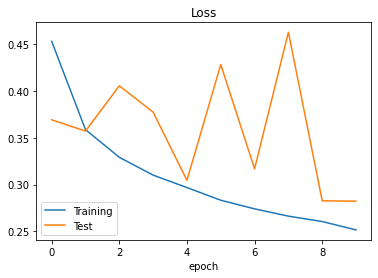

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Test'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

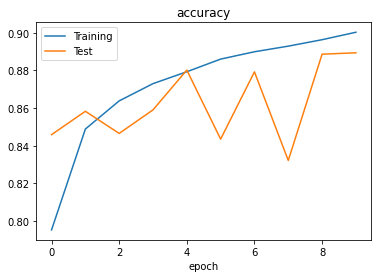

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Test'])
plt.title('accuracy')
plt.xlabel('epoch')

In [ ]:
y_train_pred_prob2 = model2.predict(X_train_pad)
y_test_pred_prob2  = model2.predict(X_test_pad)

y_train_pred2 = y_train_pred_prob2.round()
y_test_pred2  = y_test_pred_prob2.round()

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [ ]:
y_test.shape

In [ ]:
score_train2 = accuracy_score(y_train, y_train_pred2)
score_test2  = accuracy_score(y_test,  y_test_pred2)

print("Accuracy (training): %.2f%%" % (100*score_train2))
print("Accuracy (test)    : %.2f%%" % (100*score_test2))


Accuracy (training): 90.01%
Accuracy (test)    : 87.60%
